In [1]:
import os
import sys
import psycopg2
from datetime import datetime
import statsmodels.api as sm
import networkx as nx
import matplotlib.pyplot as plt
import pylab as pl
import numpy as np
import itertools
from collections import Counter
import pygraphviz
from networkx.drawing.nx_agraph import graphviz_layout
from operator import itemgetter 
import math

In [2]:
db = psycopg2.connect(user="lvs215",
                                   password="",
                                   host="127.0.0.1",
                                   port="12777",
                                   database="aip")

In [3]:
queries = [
# The entire community - 0
(
    """
    SELECT id 
    FROM publications 
    WHERE year between 2011 AND 2020
    """,
    "systems-community"
),

# Workflow communities - 1
(
    """
    SELECT id 
    FROM publications 
    WHERE year between 2011 AND 2020
    AND (lower(title) LIKE '%workflow%' OR lower(abstract) LIKE '%workflow%') 
    AND (lower(title) LIKE '%schedul%' OR lower(abstract) LIKE '%schedul%')
    """,
    "workflow-community"
),

# Workflow formalisms - 2
(
    """
    SELECT id 
    FROM publications 
    WHERE year between 2011 AND 2020
    AND (lower(title) LIKE '%workflow%' OR lower(abstract) LIKE '%workflow%') 
    AND (
        (lower(title) LIKE '%formalism%' OR lower(abstract) LIKE '%formalism%') 
        OR (lower(title) LIKE '%language%' OR lower(abstract) LIKE '%language%')
    )
    """,
    "workflow-formalism-community"
),
    
# Workflow allocation - 3
(
    """
    SELECT id 
    FROM publications 
    WHERE year between 2011 AND 2020
    AND (lower(title) LIKE '%workflow%' OR lower(abstract) LIKE '%workflow%') 
    AND (
        (lower(title) LIKE '%allocat%' OR lower(abstract) LIKE '%allocat%') 
        OR (lower(title) LIKE '%schedul%' OR lower(abstract) LIKE '%schedul%') 
        OR (lower(title) LIKE '%plan%' OR lower(abstract) LIKE '%plan%')
    )
    """,
    "workflow-allocation-community"
),

    
# Resource provisioning communities - 4
(
    """
    SELECT id 
    FROM publications 
    WHERE year between 2011 AND 2020
    AND (lower(title) LIKE '%workflow%' OR lower(abstract) LIKE '%workflow%') 
    AND (
        lower(title) LIKE '%provision%' OR lower(abstract) LIKE '%provision%' 
        OR lower(title) LIKE '%autoscal%' OR lower(abstract) LIKE '%autoscal%'
    )
    """,
    "resource-provisioning-community"
),

# applications and services - 5
(
    """
    SELECT id 
    FROM publications 
    WHERE year between 2011 AND 2020
    AND (lower(title) LIKE '%cloud%' OR lower(abstract) LIKE '%cloud%') 
    AND (lower(title) LIKE '%service%' OR lower(abstract) LIKE '%service%')
    """,
    "applications-and-services-community"
),
]

In [4]:
def generate_violinplot_author_article_count(search_query, community_string):
    query = """
        SELECT count(*)
        FROM publications p JOIN author_paper_pairs app ON CAST(p.id AS VARCHAR) = app.paper_id
        WHERE p.id IN ({}) 
        GROUP BY author_id
    """.format(search_query)
    
    with db:
        with db.cursor() as cursor:
            cursor.execute(query)
            article_count_per_author = [d[0] for d in cursor.fetchall()]
    
#     fig, ax = plt.subplots(figsize=(16,12)) 
   
#     plot = ax.violinplot(article_count_per_author, showmedians=True, showmeans=True, vert=False)

#     # Set a custom marker for the average
#     # see https://stackoverflow.com/questions/44253808/change-mean-indicator-in-violin-plot-to-a-circlea
#     xy = [[l.vertices[:, 0].mean(), l.vertices[0, 1]] for l in plot['cmeans'].get_paths()]
#     xy = np.array(xy)

#     # ax.scatter(xy[:, 0], xy[:, 1], s=121, c="crimson", marker="x", zorder=3)
#     ax.scatter(xy[:, 0], [round(i) for i in xy[:, 1]], s=121, c="crimson", marker="x", zorder=4)

#     # make lines invisible
#     plot['cmeans'].set_visible(False)

#     # Set a custom marker per median
#     xy = [[l.vertices[:, 0].mean(), l.vertices[0, 1]] for l in plot['cmedians'].get_paths()]
#     xy = np.array(xy)

#     ax.scatter(xy[:, 0], [round(i) for i in xy[:, 1]], s=400, c="green", marker=".", linewidth=2.2, zorder=3)

#     plot['cmedians'].set_visible(False)

#     # Create a line for the 25 and 75th percentile
#     quartile1, quartile3 = np.percentile(article_count_per_author, [25, 75], axis=0)
#     ax.scatter([1, 1], [quartile1, quartile3], s=121, c="blue", marker="_", linewidth=2,
#                zorder=2)

#     ax.margins(0.05)  # Optional

#     ax.set_xlabel("Number of Articles Authored", fontsize=40)
#     ax.set_ylabel("Density", fontsize=40)
#     ax.set_xlim(0, max(article_count_per_author))


#     for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
#         item.set_fontsize(34)
    
#     fig.savefig('author_article_count_distribution_{}_violinplot.pdf'.format(community_string))
    
# Old code:
#     n_bins = len(np.unique(article_count_per_author))
#     fig, ax = plt.subplots(figsize=(16,12))
    
#     n, bins, patches = ax.hist(article_count_per_author, n_bins, density=True, histtype='step', cumulative=True, 
#                                linewidth=5)

    fig, ax = plt.subplots(figsize=(16,12))
    ecdf = sm.distributions.ECDF(article_count_per_author)

    x = np.linspace(min(article_count_per_author), max(article_count_per_author))
    y = ecdf(x)
    ax.step(x, y)
    
    ax.set_xlabel("Number of Articles Authored", fontsize=50)
    ax.set_ylabel("Likelyhood", fontsize=50)
    ax.set_xlim(0, None)
    ax.set_ylim(0, None)
    
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(44)
    
    fig.tight_layout()
    date_time = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
    fig.savefig('author_article_count_distribution_{}_cdf_{}.pdf'.format(community_string, date_time))

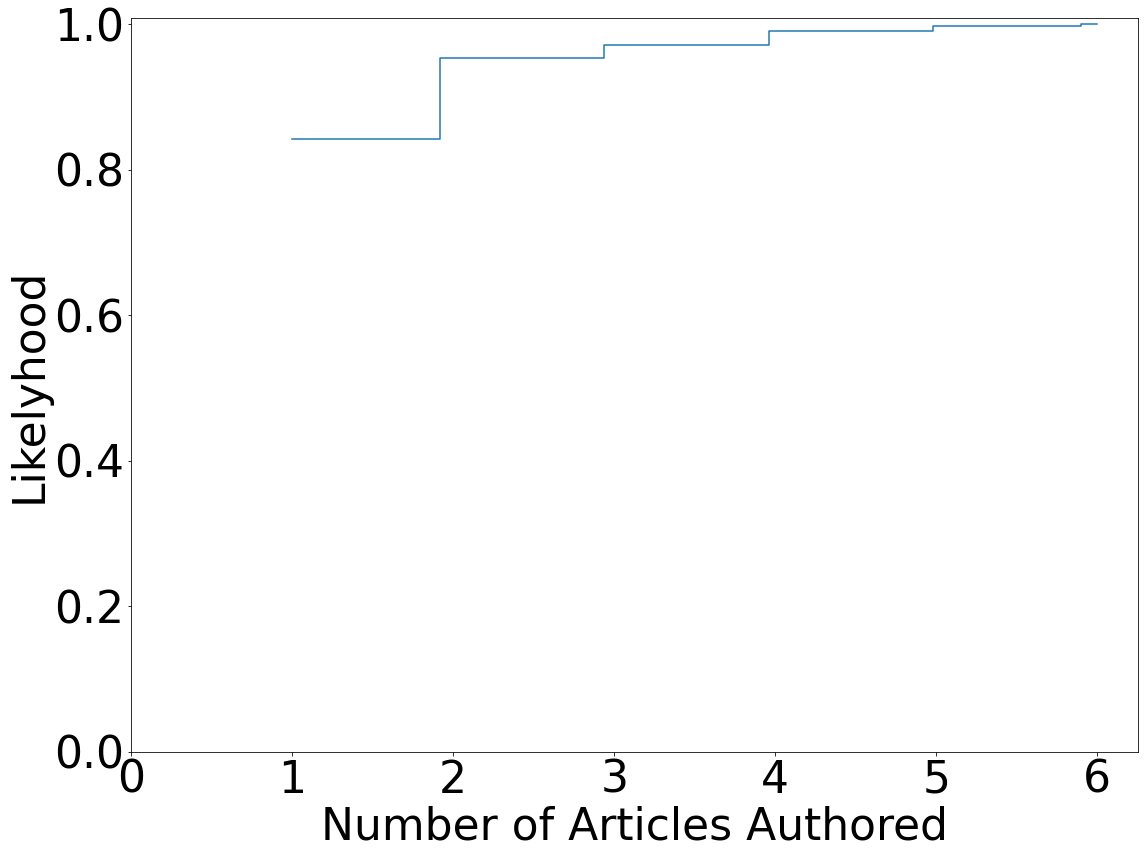

In [5]:
search_query, community_string = queries[4]
generate_violinplot_author_article_count(search_query, community_string)

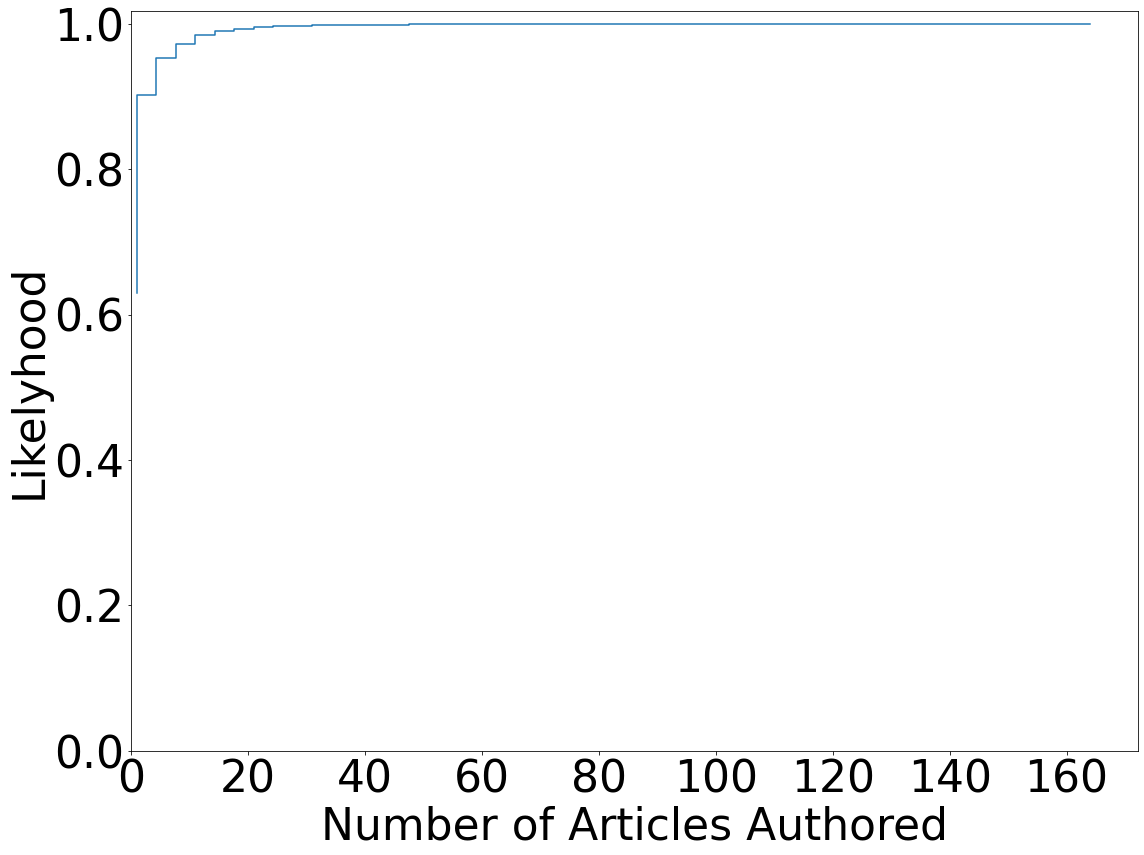

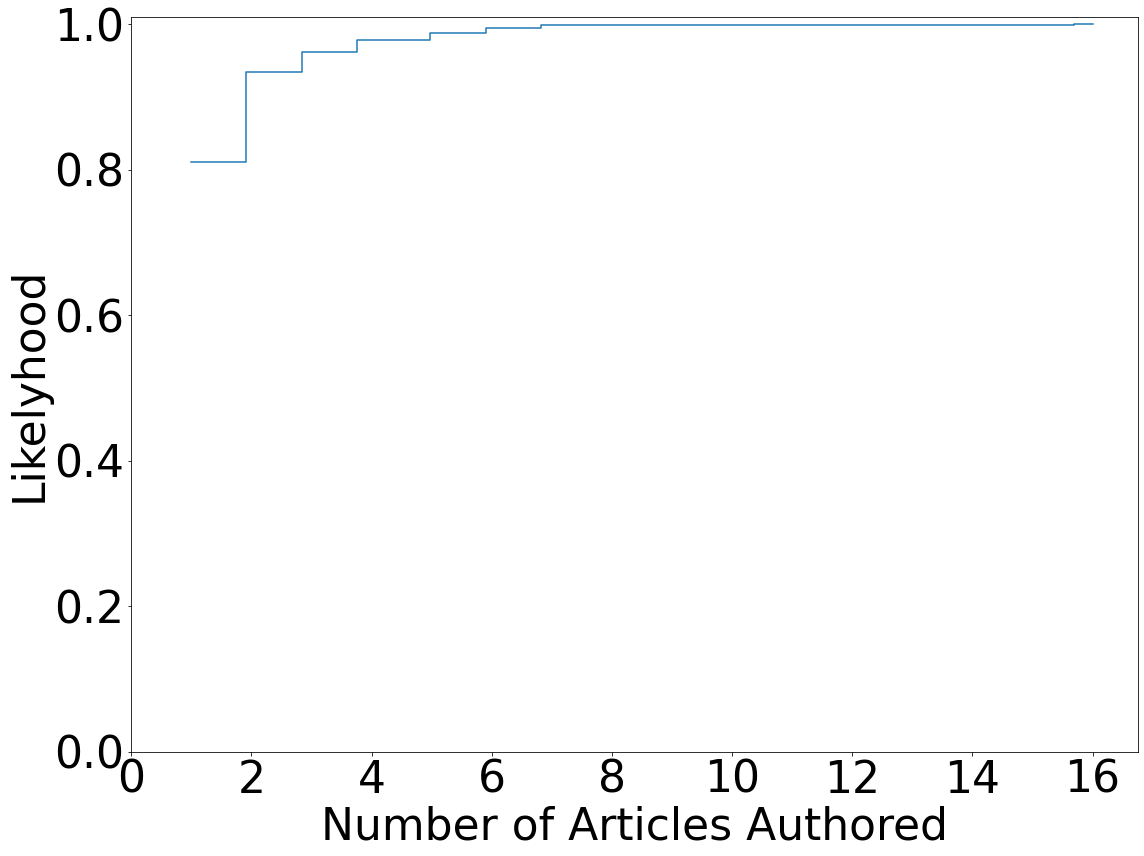

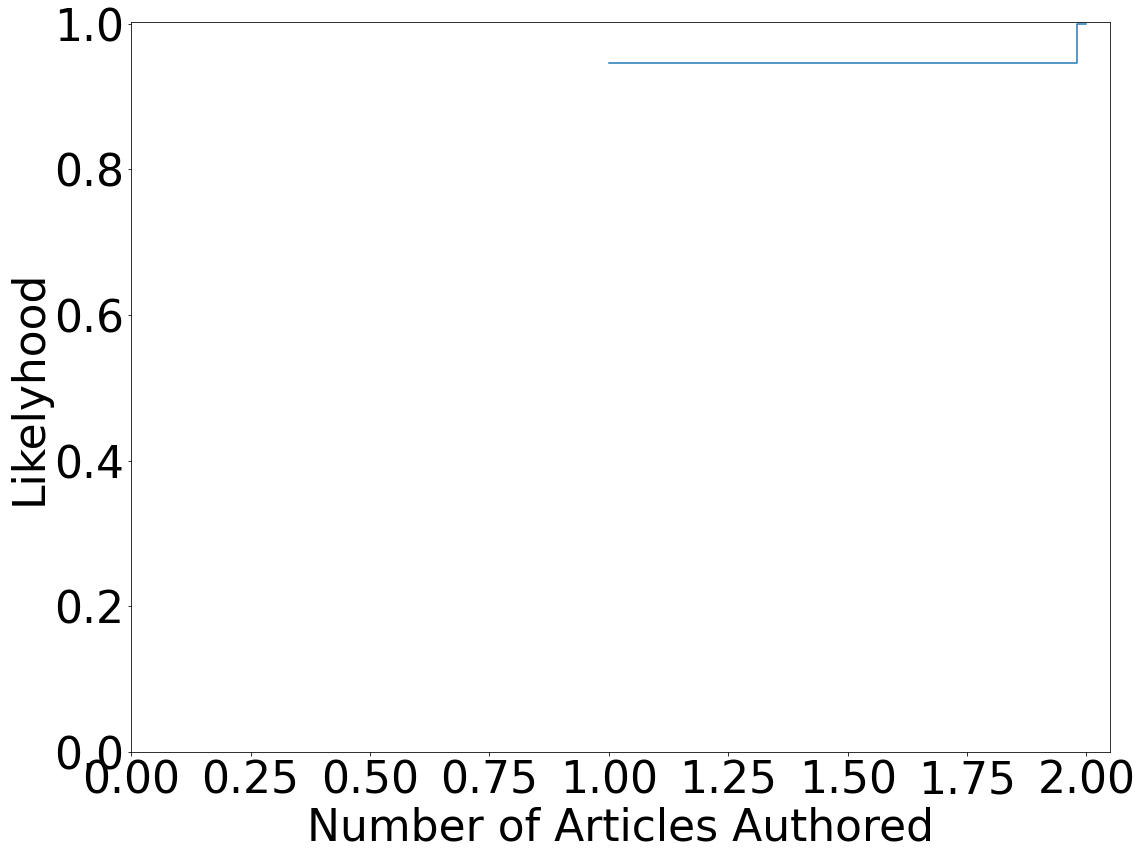

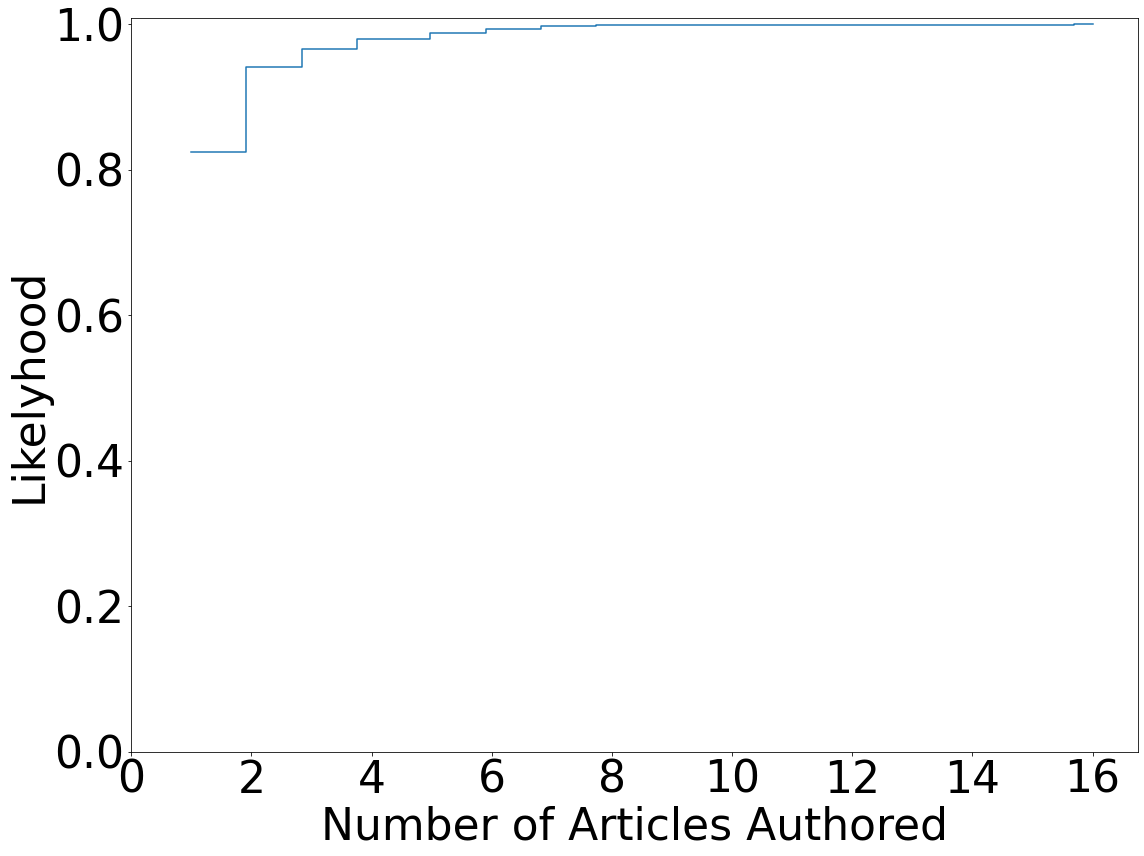

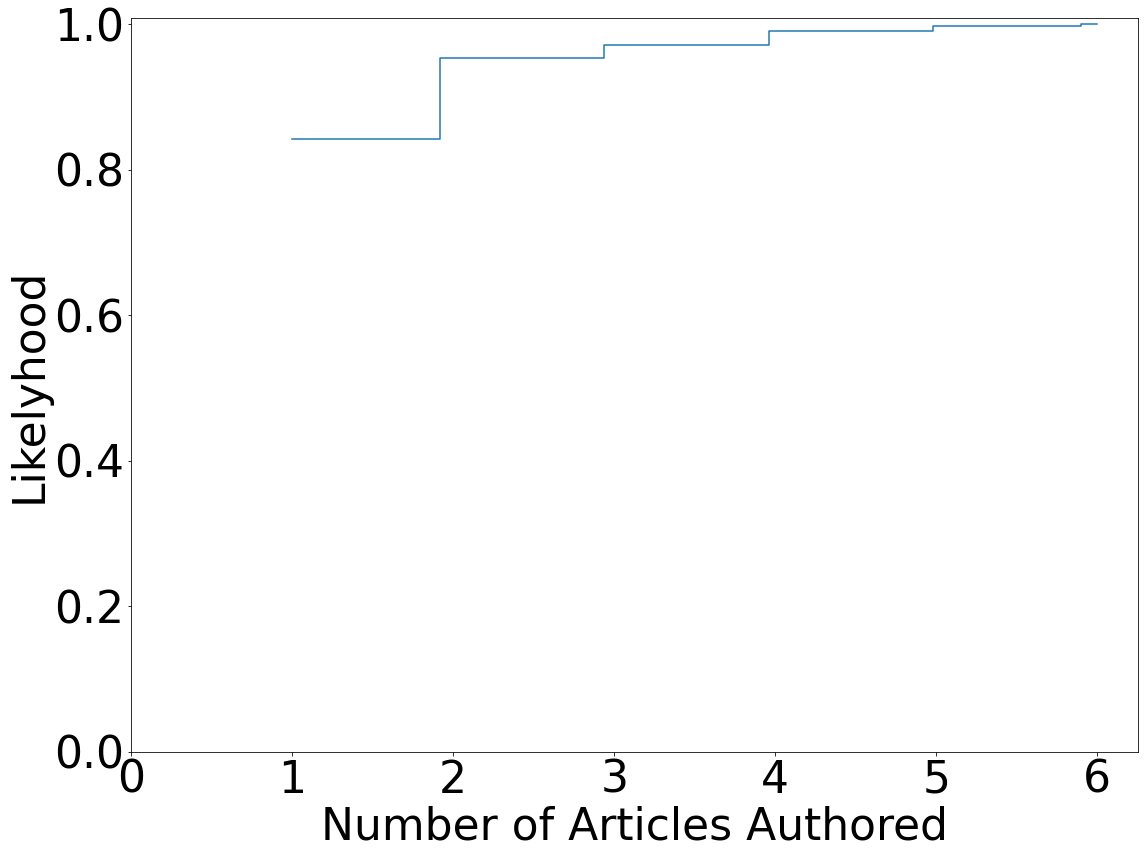

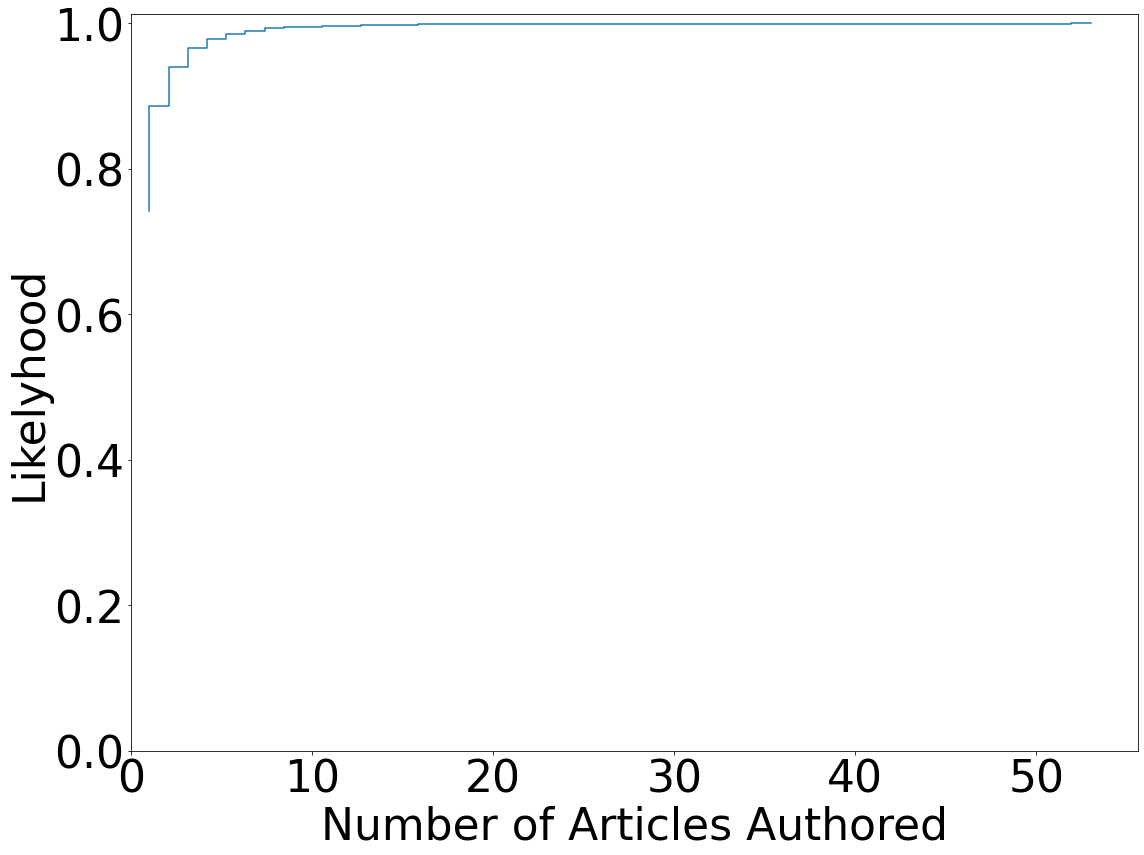

In [6]:
for search_query, community_string in queries:
    generate_violinplot_author_article_count(search_query, community_string)